# Geometric Deep Learning

**Goal:** Keep track of the positional information all the way through the pairing algorithm.

In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import uproot
import json
import matplotlib.pyplot as plt

import math

import networkx as nx
import torch
from torch import nn
import torch.nn.functional as F
from itertools import combinations


from preprocess import getNumPairs, scale, transformData, prepareData
from trainNet import getGNNDataLoaders, pairAGraph, check_accuracy

import os
os.sys.path.append('../code')
from analysis import normalizeWeight
from eventDisplays import truthDisplay

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Finish the pre-processing!!

In [14]:
reload = True

physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

fName = "df_3b.h5"

In [3]:
# I don't want all the columns... so just load a few
jetVars = ['pt','eta','phi','E','Db']
loadCols = ['j{}_{}'.format(i,v) for i in range(nSelectedJets) for v in jetVars]
loadCols += ['mc_sf','njets','nbtags','correctPair','selJet_correctPair','eventNumber','runNumber']

Scaling pt.
Scaling E.


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25',
       'HLT_j100_2j55_bmv2c2060_split', 'HLT_j225_bmv2c2060_split',
       'HLT_2j15_gsc35_bmv2c1040_split_2j15_gsc35_boffperf_split_L14J15.0ETA25',
       'HLT_2j35_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21',
       'HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30',
       'HLT_j225_gsc300_bmv2c1070_split',
       'HLT_j35_gsc55_bmv2c1050_split_ht700_L1HT190-J15s5.ETA21',
       'HLT_2j45_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21',
       'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25',
       'HLT_j110_gsc150_boffperf_split_2j45_gsc55_bmv2c1070_split_L1J85_3J30'],
      dtype='object')]

  encoding=encoding,


Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16a_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16d_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16e_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5


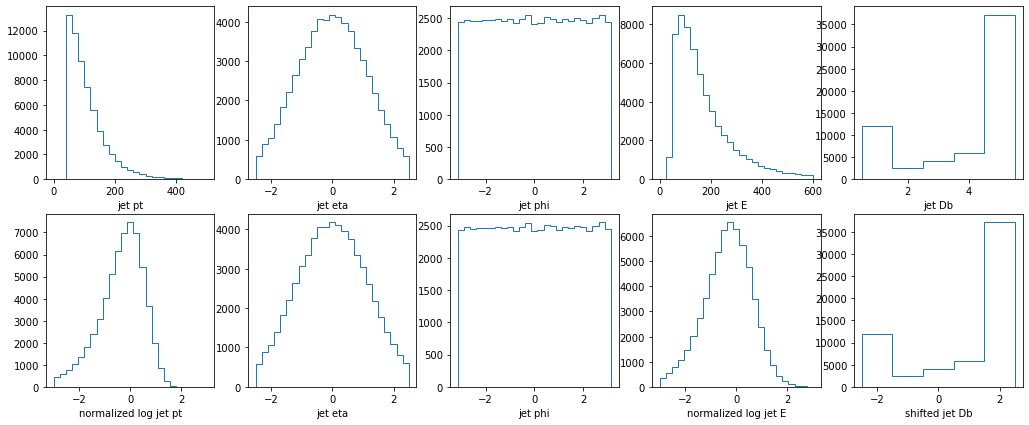

In [4]:
prepareData(prodTag=prodTag)

In [5]:
subDir = f'{physicsSample}_mc16a_PFlow-{prodTag}-{nSelectedJets}jets'

df = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
# And then select the test set
df = df[df.index % 2 == 0]

In [6]:
for c in df.columns:
    print(c)

eventNumber
nresolvedJets
resolved_nBTags
mcEventWeight
weight_pileup
rand_run_nr
j0_pt
j0_eta
j0_phi
j0_E
j0_Db
j0_sf
j1_pt
j1_eta
j1_phi
j1_E
j1_Db
j1_sf
j2_pt
j2_eta
j2_phi
j2_E
j2_Db
j2_sf
j3_pt
j3_eta
j3_phi
j3_E
j3_Db
j3_sf
j4_pt
j4_eta
j4_phi
j4_E
j4_Db
j4_sf
njets
HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25
HLT_j100_2j55_bmv2c2060_split
HLT_j225_bmv2c2060_split
trigger
mc_sf
ntag
h0_pt
h0_eta
h0_phi
h0_barcode
h1_pt
h1_eta
h1_phi
h1_barcode
b0_pt
b0_eta
b0_phi
b0_parent_barcode
b1_pt
b1_eta
b1_phi
b1_parent_barcode
b2_pt
b2_eta
b2_phi
b2_parent_barcode
b3_pt
b3_eta
b3_phi
b3_parent_barcode
truth_mhh
truth_pthh
b0_jidx
b0_drMatch
b1_jidx
b1_drMatch
b2_jidx
b2_drMatch
b3_jidx
b3_drMatch
j0_bidx
j1_bidx
j2_bidx
j3_bidx
j4_bidx
j0_drMatch
j1_drMatch
j2_drMatch
j3_drMatch
j4_drMatch
correctPair
sameParent
unique
dRmatch
goodJets
ml_j0_pt
ml_j1_pt
ml_j2_pt
ml_j3_pt
ml_j4_pt
ml_j0_eta
ml_j1_eta
ml_j2_eta
ml_j3_eta
ml_j4_eta
ml_j0_phi
ml_j1_phi
ml_j2_phi
ml_j3_phi
ml_j4_phi
ml_j0_E
ml_

In [7]:
loader_train, loader_val = getGNNDataLoaders(2048,nSelectedJets=nSelectedJets,prodTag=prodTag,
                                             jetVars=['eta','phi','pt','E','Db'])

350932  train + val events


In [8]:
for batch in loader_train:
    break

In [9]:
xi = batch[0]

In [10]:
torch.__version__

'1.5.1'

In [22]:
GNNParams= {'physicsSample': 'SMNR',
            'mc': 'mc16ade',
            'prodTag': 'AUG2019',
            'nSelectedJets': 5,
            'nLayers': 1,
            'embed_dim': 20, 
            'ff_dim': 20,
            'nHeads': 4,
            'dpt': 0.3,
            'lr': 0.01,
            'epoch': 19}

nLayers, embed_dim, ff_dim = GNNParams['nLayers'], GNNParams['embed_dim'], GNNParams['ff_dim']
nHeads, dpt, lr, epoch = GNNParams['nHeads'], GNNParams['dpt'], GNNParams['lr'], GNNParams['epoch']

# Load in the model
model = pairAGraph(inpt_dim=len(jetVars),embed_dim=embed_dim,ff_dim=ff_dim,
                   nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets,
                   spatialInfo=True)

params = sum([np.prod(p.size()) for p in model.parameters()])
params

4732

In [12]:
model.embed_dim

22

In [23]:
scores,edges = model(xi)

In [ ]:
torch.argmax(scores,axis=1)

In [311]:
h.shape

torch.Size([5, 2048, 22])

In [274]:
xin = xi.permute(1,0,2)

In [275]:
xin.shape

torch.Size([5, 2048, 5])

In [277]:
hnew = torch.cat([h,xin[:,:,:2]],axis=-1)
hnew.shape

torch.Size([5, 2048, 20])

In [284]:
x = xi

In [300]:
x.shape[0]

2048

In [ ]:
testScores = model.drSqd(x)

In [305]:
drSqd = torch.cat([(torch.pow(x[:,h11,0]-x[:,h12,0],2) + torch.pow(x[:,h21,0]-x[:,h22,0],2)+\
                    torch.pow(torch.acos(torch.cos(x[:,h11,1]-x[:,h12,1])),2)+\
                    torch.pow(torch.acos(torch.cos(x[:,h21,1]-x[:,h22,1])),2)).view(x.shape[0],-1)
                    for i0,i1,i2,i3 in combinations(range(nSelectedJets),4) \
                    for (h11,h12), (h21, h22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)])],axis=1)

In [295]:
x.shape

torch.Size([2048, 5, 5])

In [296]:
30720/2048

15.0

In [306]:
drSqd[0]

tensor([ 1.4354,  6.3016,  6.4260,  7.3350,  6.4628, 10.9604,  8.6586,  9.1150,
        13.4881,  9.7484, 11.0768,  9.7116,  9.6619, 10.8660,  5.1276])

In [302]:
drSqd.shape

torch.Size([2048, 15])

In [268]:
#modelDir = 'models/SMNR_mc16ade_PFlow-MAR2020-5jets/xformer_1layers_dim20_ff20_4heads_dpt0.3_lr0.01_batch2048/'
#modelDir = f"models/{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets/xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_lr{lr}_batch2048"
# model.load_state_dict(torch.load(f'{modelDir}/model_epoch35.pt',map_location='cpu'))
# model.eval()

In [15]:
s,w = model(xi)

In [16]:
xi.shape

torch.Size([2048, 5, 5])

**Delving in a bit to the corresponding trainable parameters**

In [17]:
#?nn.MultiheadAttention

In [18]:
class attnTest(nn.Module):
    
    def __init__(self):
        super(attnTest, self).__init__()
        self.l = nn.MultiheadAttention(20,4,kdim=18,vdim=18)
    def forward(self,xt):
        print(xt.shape)
        return self.l(xt,xt[:,:,2:],xt[:,:,2:])

In [22]:
xt = torch.rand((5,1,20))
t = attnTest()
xform_val, attn_w = t(xt)

attnTest(
  (l): MultiheadAttention(
    (out_proj): Linear(in_features=20, out_features=20, bias=True)
  )
)

In [20]:
for param in t.parameters():
    print(type(param),param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([20, 20])
<class 'torch.nn.parameter.Parameter'> torch.Size([20, 18])
<class 'torch.nn.parameter.Parameter'> torch.Size([20, 18])
<class 'torch.nn.parameter.Parameter'> torch.Size([60])
<class 'torch.nn.parameter.Parameter'> torch.Size([20, 20])
<class 'torch.nn.parameter.Parameter'> torch.Size([20])


Ok - so I wanted to build this up slowly so I could *see* the individual steps of the model working. Before training, I want to get some metric evaluation code up and running.

In [28]:
df

eventNumber  nresolvedJets  resolved_nBTags  mcEventWeight  \
entry                                                                
0               442              4                3       0.120290   
2              1088              6                4       0.037104   
14             1974              6                3       0.116338   
22             1823              6                3       0.083696   
24             1931              7                3      -0.085212   
...             ...            ...              ...            ...   
777124       473929              4                3       0.012496   
777126       473389              8                4       0.030191   
777142       484936              6                4       0.022994   
777144       473562              4                4      -0.063138   
777146       484890              7                3       0.033298   

        weight_pileup  rand_run_nr       j0_pt    j0_eta    j0_phi  \
entry                                                                
0            0.832972       310863   65.844810  0.146446  2.467891   
2            0.913518       307619  141.734589 -1.114459  0.415969   
14           1.124388       303421   95.889526 -1.953326  2.524543   
22           0.913518       311321  332.366669  0.302779  1.854437   
24           0.874238       304198  209.542023 -0.134799 -1.734556   
...               ...          ...         ...       ...       ...   
777124       0.980906       308084  353.294006 -0.191125 -2.715050   
777126       0.906756       303208  326.066956 -1.914548  1.052918   
777142       0.913518       302737  223.975311  0.642214 -1.218025   
777144       1.193475       280753  188.015274  0.306945 -2.609013   
777146       1.152634       310809  197.907532 -1.820346  1.200698   

               j0_E  ...   ml_j0_E   ml_j1_E   ml_j2_E   ml_j3_E   ml_j4_E  \
entry                ...                                                     
0         67.811531  ... -0.687443  0.121061  0.740119 -0.675361  0.000000   
2        240.037628  ...  0.529204 -0.115811  0.255826 -0.265312 -0.091691   
14       345.063019  ...  0.878522  0.217350 -0.302329 -0.799606 -1.023935   
22       348.910309  ...  0.889194  1.155624  0.893902  0.104622 -1.135157   
24       213.012665  ...  0.414240  0.711263  0.437440 -0.486216 -0.862263   
...             ...  ...       ...       ...       ...       ...       ...   
777124   360.129883  ...  0.919656  0.254847 -0.173635  0.327599  0.000000   
777126  1130.196411  ...  2.020438  1.500051  0.376308  0.081505  0.241208   
777142   273.181763  ...  0.653694  0.652065  0.304176  0.229548  0.000000   
777144   197.268982  ...  0.340337  0.377580 -0.171817 -0.823062  0.000000   
777146   627.856567  ...  1.454653  0.186350 -0.133492 -0.842520  0.000000   

        ml_j0_Db  ml_j1_Db  ml_j2_Db  ml_j3_Db  ml_j4_Db  
entry                                                     
0            3.5       3.5       3.5       3.5       0.0  
2            3.5       3.5       3.5       3.5       3.5  
14           3.5       3.5       3.5       3.5       3.5  
22           3.5       3.5       3.5       3.5       3.5  
24           3.5       3.5       3.5       3.5       3.5  
...          ...       ...       ...       ...       ...  
777124       3.5       3.5       3.5       3.5       0.0  
777126       3.5       3.5       3.5       3.5       3.5  
777142       3.5       3.5       3.5       3.5       0.0  
777144       3.5       3.5       3.5       3.5       0.0  
777146       3.5       3.5       3.5       3.5       0.0  

[161508 rows x 125 columns]

**Step 1:** What would be the accuracy of *just* using the scaled $\eta$ and $\phi$ as a metric?

**Note to self:** I had made the choice before *not* to transform $\eta$ and $\phi$ in the ML pre-processing

In [260]:
cols = [f'j{i}_{v}' for i in range(nSelectedJets) for v in ['eta','phi']]
df[cols]

j0_eta    j0_phi    j1_eta    j1_phi    j2_eta    j2_phi    j3_eta  \
entry                                                                          
0       0.146446  2.467891  1.680823 -1.068846  2.366143  0.850409  0.751255   
2      -1.114459  0.415969 -0.215671 -2.185306 -1.086005 -2.369699  0.401709   
14     -1.953326  2.524543 -1.279673 -0.467862 -0.728222  0.692915  0.272814   
22      0.302779  1.854437 -1.285873 -1.416614 -1.692348 -0.917993 -1.473010   
24     -0.134799 -1.734556 -1.146079  1.659323  0.905748  1.199177  0.153227   
...          ...       ...       ...       ...       ...       ...       ...   
777124 -0.191125 -2.715050  0.464938  0.875189 -0.083086  0.390297  1.668718   
777126 -1.914548  1.052918  1.491297 -2.951824  0.599131 -0.428784  1.081529   
777142  0.642214 -1.218025 -0.865532  1.705289  0.613827 -1.832809  0.718060   
777144  0.306945 -2.609013  0.881634  0.610938  0.716655 -0.494307 -0.407863   
777146 -1.820346  1.200698  0.549576 -1.749459 -0.421528 -1.894410  0.625986   

          j3_phi    j4_eta    j4_phi  
entry                                 
0      -2.326935  0.000000  0.000000  
2       2.350585 -0.829471  1.440184  
14     -3.035517 -0.202366 -2.017484  
22      1.642703  0.063536 -2.730245  
24     -2.381532 -0.229991  0.593475  
...          ...       ...       ...  
777124 -1.527385  0.000000  0.000000  
777126 -2.263388  1.349341 -1.022725  
777142  1.608912  0.000000  0.000000  
777144  2.281693  0.000000  0.000000  
777146  1.356728  0.000000  0.000000  

[161508 rows x 10 columns]

In [225]:
X = df[cols].values.reshape(-1,nSelectedJets,2)
X.shape

(161508, 5, 2)

In [226]:
X[1,4]

array([-0.82947052,  1.44018447])

Ok - I think the transformation is happening in the expected way.

In [227]:
scores = np.vstack([np.power(X[:,h11,0]-X[:,h12,0],2) + np.power(X[:,h21,0]-X[:,h22,0],2)+\
                    np.power(np.arccos(np.cos(X[:,h11,1]-X[:,h12,1])),2)+\
                    np.power(np.arccos(np.cos(X[:,h21,1]-X[:,h22,1])),2)
                    for i0,i1,i2,i3 in combinations(range(nSelectedJets),4) \
                    for (h11,h12), (h21, h22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)])]).T

In [228]:
scores.shape

(161508, 15)

In [229]:
from preprocess import getNumPairs

In [230]:
getNumPairs(nSelectedJets)

15

In [231]:
predPair = -np.ones_like(df.correctPair)
print(predPair.shape)

for nj in range(4,nSelectedJets+1):
    
    predPair[df.njets==nj] = np.argmin(scores[df.njets==nj,:getNumPairs(nj)],axis=1)

df['predPair'] = predPair

(161508,)


In [232]:
acc = np.sum(df.loc[(predPair == df.correctPair)&(df.correctPair!=-1),'mcEventWeight'])/np.sum(df.loc[(df.correctPair!=-1),'mcEventWeight'])
acc

0.68510216

In [233]:
m = (df.correctPair != -1) & df.trigger & (df.njets==4)  #& (df.truth_mhh > 500) # #&( df.njets==5)
acc = np.sum(df.loc[(predPair == df.correctPair) & m,'mc_sf']) / np.sum(df.loc[m,'mc_sf'])
acc

0.9322408587170737

What would be interesting break downs?
- Number of jets
- Number of b-tags 
- With and without the trigger

In [234]:
text = "$\mathbf{ATLAS}$ Simulation Internal\n"
text += f"SM NR mc16a MAR20 MNT prod\n"
text += "Four $p_T$ > 40 GeV jets, and 3b at DL1r 77% WP"

true pair $\exists$ 68.55766042278141 %
true pair $\exists$ & passed trigger 69.23584049686234 %


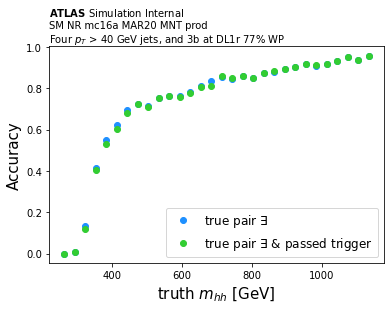

In [235]:
nb, r = 30, (250,1150)

for m,l,c in zip([(df.correctPair != -1), (df.correctPair != -1) & df.trigger],
                 ['true pair $\exists$','true pair $\exists$ & passed trigger'],
                 ['dodgerblue','limegreen']):
    
    ns, e = np.histogram(df.loc[(predPair == df.correctPair) & m,'truth_mhh'], nb,r,
                         weights=df.loc[(predPair == df.correctPair) & m,'mc_sf']) 
    ds, _ = np.histogram(df.loc[m,'truth_mhh'], nb,r, weights=df.loc[m,'mc_sf']) 

    xx = 0.5 * (e[:-1]+e[1:])
    plt.plot(xx,ns/ds,'o',color=c,label=l)

    acc = np.sum(df.loc[(predPair == df.correctPair) & m,'mc_sf']) /np.sum(df.loc[m,'mc_sf'])
    print(l,acc*100,'%')
    
plt.xlabel('truth $m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'figures/SMNR_mc16a_PFlow-MAR2020-5jets/acc_inclusive.pdf')
plt.show()

Now break down by # of b-tags and jet multiplicity!

4 jets, 4b 88.90224242743632 %
4 jets, 3b 90.01896447871131 %
5 jets, 4b 49.14916588887678 %
5 jets, 3b 49.29769698320439 %


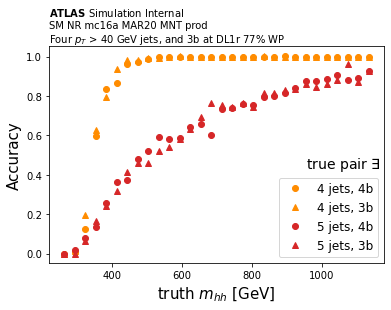

4 jets, 4b 93.15840503098232 %
4 jets, 3b 93.27400939825635 %
5 jets, 4b 50.093439077473114 %
5 jets, 3b 50.163391530193465 %


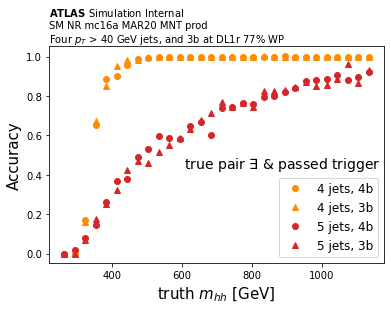

In [236]:
for m,t,tag in zip([(df.correctPair != -1), (df.correctPair != -1) & df.trigger],
                   ['true pair $\exists$','true pair $\exists$ & passed trigger'], 
                   ['','_trigger']):

    plt.figure()
    for nj,c in zip([4,5], ['darkorange','C3']):
         
        # 4b
        mask = m & (df.njets == nj) & (df.ntag >= 4)
        ns, e = np.histogram(df.loc[(predPair == df.correctPair) & mask,'truth_mhh'], nb,r,
                             weights=df.loc[(predPair == df.correctPair) & mask,'mc_sf']) 
        ds, _ = np.histogram(df.loc[mask,'truth_mhh'], nb,r, weights=df.loc[mask,'mc_sf']) 

        xx = 0.5 * (e[:-1]+e[1:])
        plt.plot(xx,ns/ds,'o',color=c,label=f'{nj} jets, 4b')

        acc = np.sum(df.loc[(predPair == df.correctPair) & mask,'mc_sf']) /np.sum(df.loc[mask,'mc_sf'])
        print(f'{nj} jets, 4b',acc*100,'%')
        
        # 3b
        mask = m & (df.njets == nj) & (df.ntag == 3)
        ns, e = np.histogram(df.loc[(predPair == df.correctPair) & mask,'truth_mhh'], nb,r,
                             weights=df.loc[(predPair == df.correctPair) & mask,'mc_sf']) 
        ds, _ = np.histogram(df.loc[mask,'truth_mhh'], nb,r, weights=df.loc[mask,'mc_sf']) 

        xx = 0.5 * (e[:-1]+e[1:])
        plt.plot(xx,ns/ds,'^',color=c,label=f'{nj} jets, 3b')
        
        acc = np.sum(df.loc[(predPair == df.correctPair) & mask,'mc_sf']) /np.sum(df.loc[mask,'mc_sf'])
        print(f'{nj} jets, 3b',acc*100,'%')
        
    plt.xlabel('truth $m_{hh}$ [GeV]',fontsize=15)
    plt.ylabel('Accuracy',fontsize=15)
    plt.legend(fontsize=12)

    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

    plt.text(.99,.5,t,ha='right',va='top',transform=ax.transAxes,fontsize=14)

    plt.savefig(f'figures/SMNR_mc16a_PFlow-MAR2020-5jets/acc_njet_ntag{tag}.pdf')
    plt.show()

In [237]:
mask = (df.correctPair!=-1) & (df.correctPair!=df.predPair)
df.loc[mask,['eventNumber','correctPair','predPair']]

eventNumber  correctPair  predPair
entry                                     
22             1823           12         5
52             1069            1         4
138             232            5        11
228             409            3        10
300             865            7         2
...             ...          ...       ...
776868       473293           12         5
776900       473215            5        12
776948       484173           10         5
777040       473832            2        12
777072       473851            5         8

[15703 rows x 3 columns]

In [238]:
# Load file
mc16a_filename = "../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root"

treename = "XhhMiniNtuple" 

f = uproot.open(mc16a_filename)
tree = f[treename]

In [239]:
jvars = ['pt','eta','phi','DL1r','is_DL1r_FixedCutBEff_77','Quantile_DL1r_Continuous','HadronConeExclTruthLabelID']
jdf = tree.pandas.df([f'resolvedJets_{v}' for v in jvars])

In [240]:
df.head()

eventNumber  nresolvedJets  resolved_nBTags  mcEventWeight  \
entry                                                               
0              442              4                3       0.120290   
2             1088              6                4       0.037104   
14            1974              6                3       0.116338   
22            1823              6                3       0.083696   
24            1931              7                3      -0.085212   

       weight_pileup  rand_run_nr       j0_pt    j0_eta    j0_phi        j0_E  \
entry                                                                           
0           0.832972       310863   65.844810  0.146446  2.467891   67.811531   
2           0.913518       307619  141.734589 -1.114459  0.415969  240.037628   
14          1.124388       303421   95.889526 -1.953326  2.524543  345.063019   
22          0.913518       311321  332.366669  0.302779  1.854437  348.910309   
24          0.874238       304198  209.542023 -0.134799 -1.734556  213.012665   

       ...  ml_j2_Db  ml_j3_Db  ml_j4_Db  predPair  correctPair_old  \
entry  ...                                                            
0      ...       3.5       3.5       0.0         2                2   
2      ...       3.5       3.5       3.5         5               12   
14     ...       3.5       3.5       3.5        12               -1   
22     ...       3.5       3.5       3.5         5               12   
24     ...       3.5       3.5       3.5        10               10   

       j1_bidx_new  j0_bidx_new  j2_bidx_new  j3_bidx_new  j4_bidx_new  
entry                                                                   
0              1.0          0.0          3.0          2.0          NaN  
2              2.0          0.0          1.0          NaN          3.0  
14             0.0          NaN          1.0          2.0          NaN  
22             0.0          NaN          1.0          2.0          3.0  
24             NaN          0.0          1.0          2.0          3.0  

[5 rows x 132 columns]

In [241]:
from preprocess import parallelGetCorrectPair

In [242]:
parallelGetCorrectPair(df,5)

In [243]:
df.correctPair

entry
0          2
2          5
14        -1
22        12
24        10
          ..
777124    -1
777126    13
777142    -1
777144     2
777146    -1
Name: correctPair, Length: 161508, dtype: int64

In [244]:
# i = 0
        
# for i0,i1,i2,i3 in combinations(range(nSelectedJets),4):
#     print(f'{i:2d}. ({i0},{i1}) & ({i2},{i3})')
#     print(f'{i+1:2d}. ({i0},{i2}) & ({i1},{i2})')
#     print(f'{i+2:2d}. ({i0},{i3}) & ({i1},{i2})')
#     i +=3

In [245]:
jdf.head()

resolvedJets_pt  resolvedJets_eta  resolvedJets_phi  \
entry subentry                                                        
0     0               65.844810          0.146446          2.467891   
      1               56.410419          1.680823         -1.068846   
      2               55.581108          2.366143          0.850409   
      3               52.658108          0.751255         -2.326935   
1     0              252.587738          0.840473         -1.964215   

                resolvedJets_DL1r  resolvedJets_is_DL1r_FixedCutBEff_77  \
entry subentry                                                            
0     0                  7.535639                                     1   
      1                 -0.508439                                     0   
      2                  6.180948                                     1   
      3                 11.175610                                     1   
1     0                  6.798305                                     1   

                resolvedJets_Quantile_DL1r_Continuous  \
entry subentry                                          
0     0                                             5   
      1                                             1   
      2                                             5   
      3                                             5   
1     0                                             5   

                resolvedJets_HadronConeExclTruthLabelID  
entry subentry                                           
0     0                                               5  
      1                                               0  
      2                                               5  
      3                                               5  
1     0                                               5

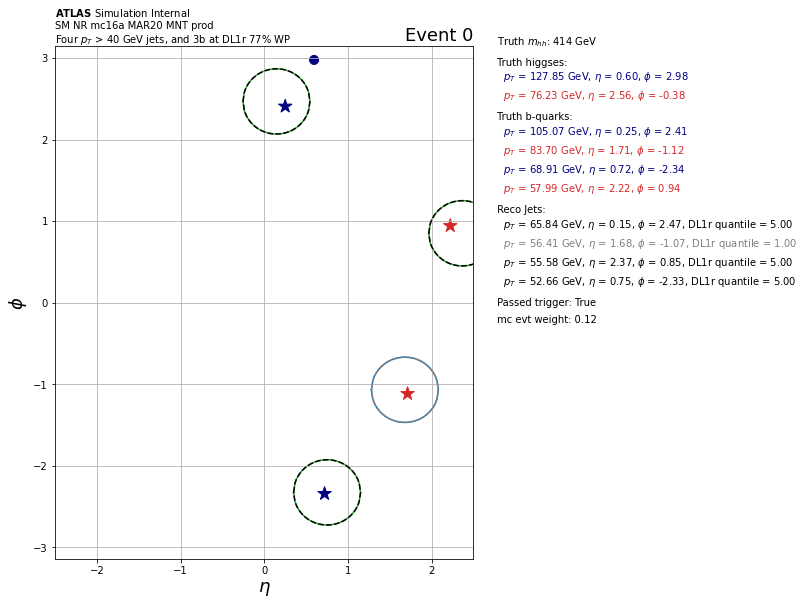

In [246]:
truthDisplay(0,df,triggerKey=True,mode=1,jdf=jdf,tagger='DL1r',WP=77,quantile=True,
             text=text,figDir='figures/SMNR_mc16a_PFlow-MAR2020-5jets/intuitionBuilding')

**Let's also look at some cases the preprocessing is not enough:**

In [247]:
df.loc[2,['j0_pt','j1_pt','j2_pt','j3_pt','j4_pt','truth_mhh']]

j0_pt        141.735
j1_pt        119.388
j2_pt        108.975
j3_pt        96.4254
j4_pt        92.0379
truth_mhh    574.711
Name: 2, dtype: object

In [248]:
df.loc[2,['j0_bidx','j1_bidx','j2_bidx','j3_bidx','j4_bidx']]

j0_bidx     0
j1_bidx     2
j2_bidx     1
j3_bidx    -1
j4_bidx     3
Name: 2, dtype: object

In [249]:
scores[1]

array([12.23040414, 11.19495578,  6.83298743, 13.75748214, 15.2008549 ,
        1.92171901,  9.91908421, 13.48159788,  4.56443033, 10.10539239,
       12.22453329,  5.78618686,  3.13611574,  9.61722499, 12.09604611])

In [250]:
(-1.11+.82)**2 + (1.42-.42)**2 + (-1.12+.28)**2 + (-2.4+2.15)**2

1.8522000000000003

In [251]:
pairs = [((h11,h12), (h21, h22)) for i0,i1,i2,i3 in combinations(range(nSelectedJets),4) \
         for (h11,h12), (h21, h22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)])]

In [252]:
for evt in df[(df.correctPair!=df.predPair)&(df.correctPair!=-1)].index[:5]:
    print(f'Event {evt:3d}: correct pair',pairs[df.loc[evt,'correctPair']],
          ', pred pair',pairs[df.loc[evt,'predPair']])

Event  22: correct pair ((1, 2), (3, 4)) , pred pair ((0, 4), (1, 2))
Event  52: correct pair ((0, 2), (1, 3)) , pred pair ((0, 2), (1, 4))
Event 138: correct pair ((0, 4), (1, 2)) , pred pair ((0, 4), (2, 3))
Event 228: correct pair ((0, 1), (2, 4)) , pred pair ((0, 3), (2, 4))
Event 300: correct pair ((0, 3), (1, 4)) , pred pair ((0, 3), (1, 2))


In [253]:
pairs[5]

((0, 4), (1, 2))

In [254]:
pairs[12]

((1, 2), (3, 4))

In [255]:
jdf.loc[2]

resolvedJets_pt  resolvedJets_eta  resolvedJets_phi  \
subentry                                                        
0              141.734589         -1.114459          0.415969   
1              119.388428         -0.215671         -2.185306   
2              108.974922         -1.086005         -2.369699   
3               96.425415          0.401709          2.350585   
4               92.037949         -0.829471          1.440184   
5               35.655270          4.129258         -1.779163   

          resolvedJets_DL1r  resolvedJets_is_DL1r_FixedCutBEff_77  \
subentry                                                            
0                  9.190607                                     1   
1                 10.828214                                     1   
2                  4.911189                                     1   
3                 -2.801272                                     0   
4                 11.203829                                     1   
5                 -1.487941                                     0   

          resolvedJets_Quantile_DL1r_Continuous  \
subentry                                          
0                                             5   
1                                             5   
2                                             5   
3                                             1   
4                                             5   
5                                            -1   

          resolvedJets_HadronConeExclTruthLabelID  resolvedJets_label  
subentry                                                               
0                                               5                   2  
1                                               5                   2  
2                                               5                   2  
3                                               0                   0  
4                                               5                   2  
5                                               0                   0

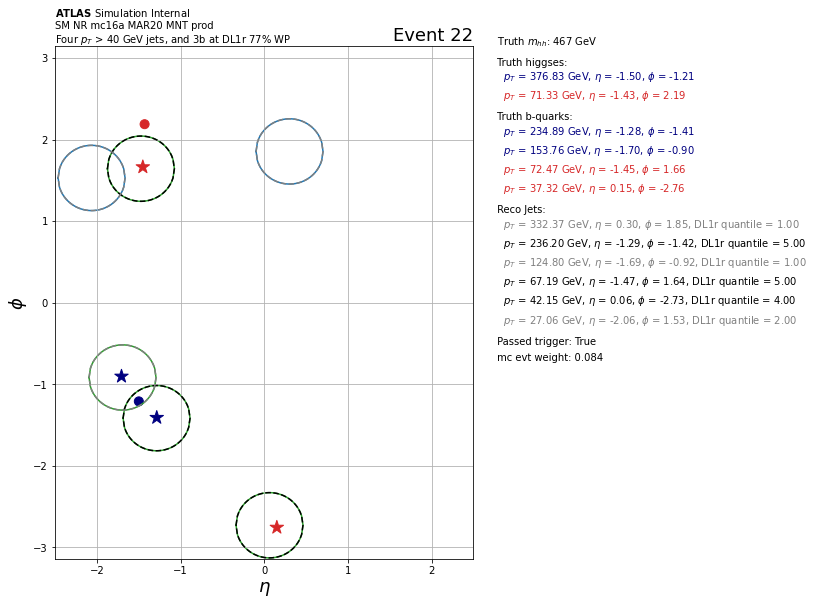

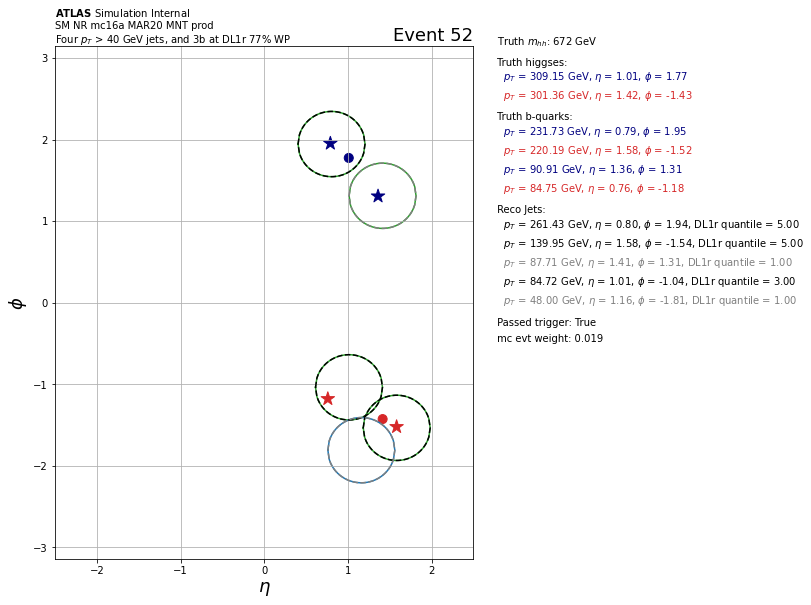

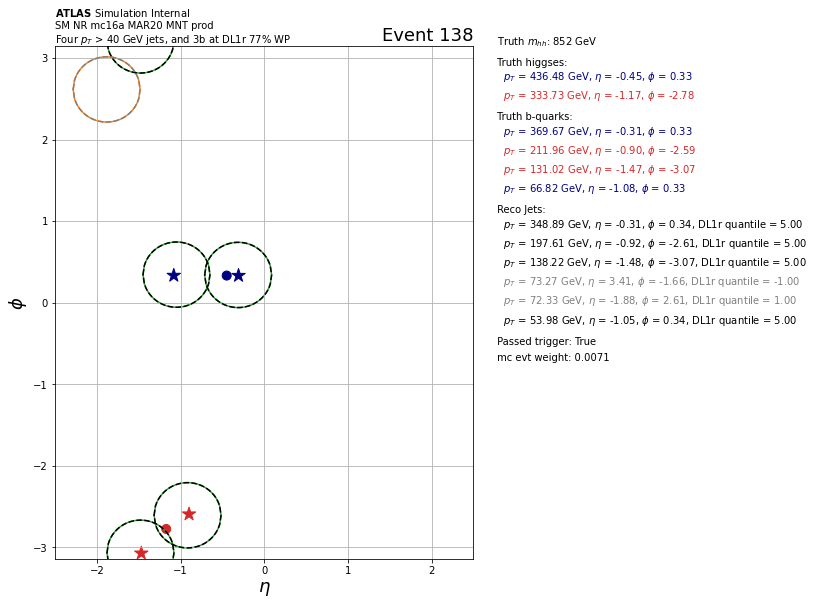

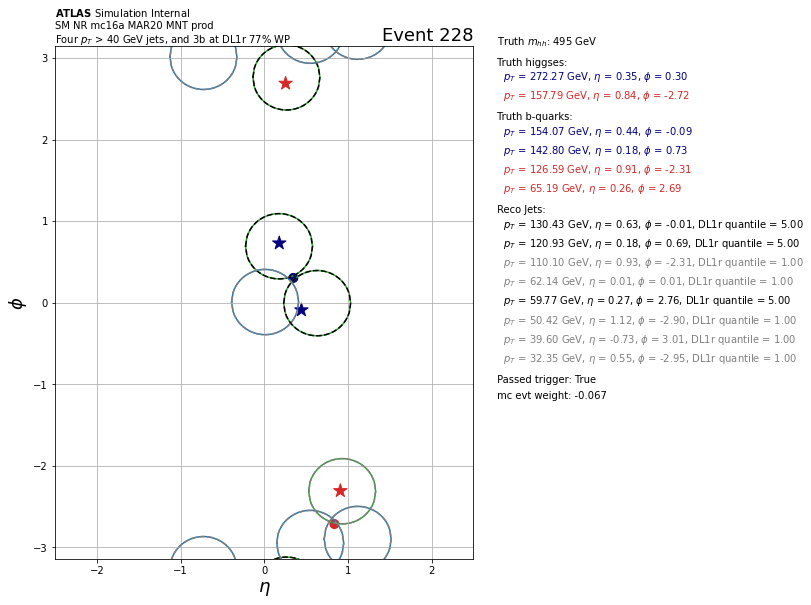

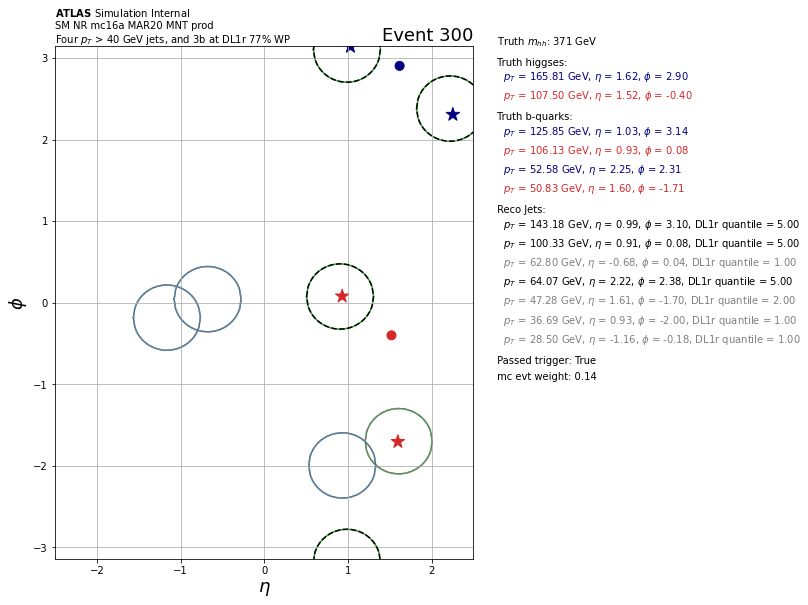

In [256]:
for evt in df[(df.correctPair!=df.predPair)&(df.correctPair!=-1)].index[:5]:
    truthDisplay(evt,df,triggerKey=True,mode=1,jdf=jdf,tagger='DL1r',WP=77,quantile=True,
                 text=text,figDir='figures/SMNR_mc16a_PFlow-MAR2020-5jets/dRSqdFails/')

In [257]:
# # Since I'm only using half the stats for the test set, need to multiply L by 2.
# L = 24.5556
# key = subDir[:-6]
# print(key)
# normalizeWeight(df,key,lumi=L*2)

# X_test = np.dstack([df[['ml_j{}_{}'.format(i,v) for i in range(nSelectedJets)]].values for v in jetVars])
# njets = np.sum(~ np.all(X_test==0, axis=-1),axis=1) 

# # Get the mask for the scores
# ttlPairs = getNumPairs(nSelectedJets)
# scoreMask = np.ones((X_test.shape[0],ttlPairs)).astype(bool)

# for ji in range(4,nSelectedJets):
#     nPairs = getNumPairs(ji)
#     scoreMask[njets==ji] *= np.array([True]*nPairs + [False]*(ttlPairs-nPairs))
    
# # Make them pytorch tensors
# X_test = torch.tensor(X_test).float().to(device)
# scoreMask = torch.tensor(scoreMask).to(device)

In [258]:
# model.to(device)
# model.eval()

# logits, edgeWeights = model(X_test)

# logits[~scoreMask] = float('-inf') # 0
# _, y_pred = torch.max(logits,1)

# y_pred = y_pred.cpu().numpy()
# edgeWeights = edgeWeights.cpu().detach().numpy()